# Training U-Net for Image Segmentation

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import utils.utils as utils
import torch
from torch.utils.data import DataLoader
import utils.load_dataset as loader
import numpy as np
from collections import Counter
from tqdm import tqdm
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF
import random
import os
from glob import glob
from torchvision.transforms import v2
from torchgeo.models import resnet18
from torchgeo.models import ResNet18_Weights
from torchsummary import summary
import utils.train as t
import model.unet as model
import torch.nn as nn
import torch.optim as optim

/home/ubuntu/miniconda3/envs/conda_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# for GPU use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Loading Dataset

In [6]:
image_paths = sorted(glob("data/patches/images/*.npy"))
mask_paths = sorted(glob("data/patches/masks/*.npy"))
dataset = loader.SatelliteDataset(image_paths, mask_paths)
print(len(dataset))

4287


## Data Preprocessing

### Data Exploration
Counting Samples for each class

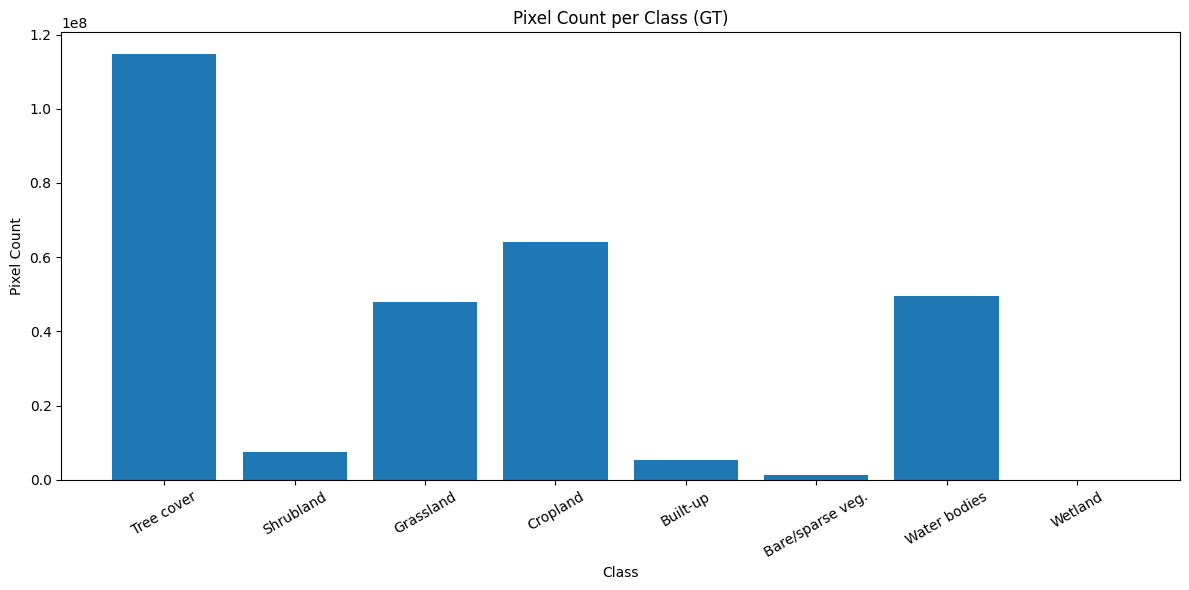

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Class name mapping
class_names = {
    0: "Tree cover",
    1: "Shrubland",
    2: "Grassland",
    3: "Cropland",
    4: "Built-up",
    5: "Bare/sparse veg.",
    6: "Snow and ice",
    7: "Water bodies",
    8: "Wetland",
    9: "Mangroves",
    10: "Moss/lichen",
}

# WorldCover to index mapping
label_mapping = {
    10: 0,
    20: 1,
    30: 2,
    40: 3,
    50: 4,
    60: 5,
    70: 6,
    80: 7,
    90: 8,
    95: 9,
    100: 10,
}

# Load ground truth mask
gt_path = "data/ground_truth/GBDA24_ex2_ref_data.tif"
with rasterio.open(gt_path) as src:
    raw_mask = src.read(1)

# Create new integer mask initialized with -1 (invalid)
mask = np.full(raw_mask.shape, fill_value=-1, dtype=np.int16)

# Remap WorldCover values to class indices
for raw_val, new_val in label_mapping.items():
    mask[raw_mask == raw_val] = new_val

# Filter out invalid values
mask = mask[mask != -1]

# Count pixel occurrences per class
unique_classes, counts = np.unique(mask, return_counts=True)
labels = [class_names[c] for c in unique_classes]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(labels, counts)
plt.title("Pixel Count per Class (GT)")
plt.ylabel("Pixel Count")
plt.xlabel("Class")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

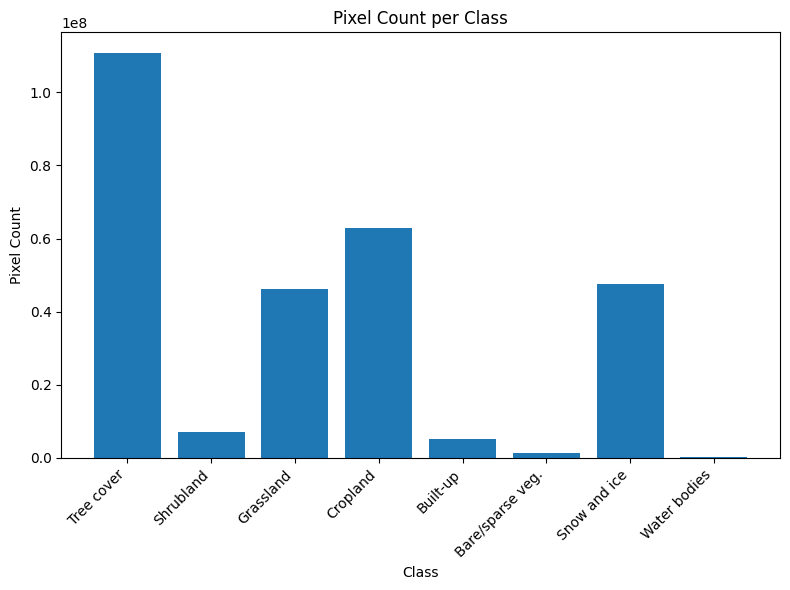

In [ ]:
pixel_class_counts = Counter()
for i in range(len(dataset)):
    _, mask = dataset[i]

    if hasattr(mask, "numpy"):
        mask = mask.numpy()
    class_counts = Counter(mask.flatten())
    pixel_class_counts.update(class_counts)

class_names = {
    0: "Tree cover",
    1: "Shrubland",
    2: "Grassland",
    3: "Cropland",
    4: "Built-up",
    5: "Bare/sparse veg.",
    6: "Snow and ice",
    7: "Water bodies",
    8: "Wetland",
    9: "Mangroves",
    10: "Moss/lichen",
}

# Create lists for plotting
classes = sorted(pixel_class_counts.keys())
counts = [pixel_class_counts[c] for c in classes]
labels = [class_names.get(c, f"Class {c}") for c in classes]

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts)
plt.title("Pixel Count per Class")
plt.xlabel("Class")
plt.ylabel("Pixel Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

Clean dataset from NaN values

In [7]:
valid = []
for i in range(len(dataset)):
    image, mask = dataset[i]
    if not (image == -9999).any().item():
        valid.append(i)

print("Initial size of dataset:", len(dataset))
clean_dataset = Subset(dataset, valid)
print("size of cleaned dataset:", len(clean_dataset))

Initial size of dataset: 4287
size of cleaned dataset: 3225


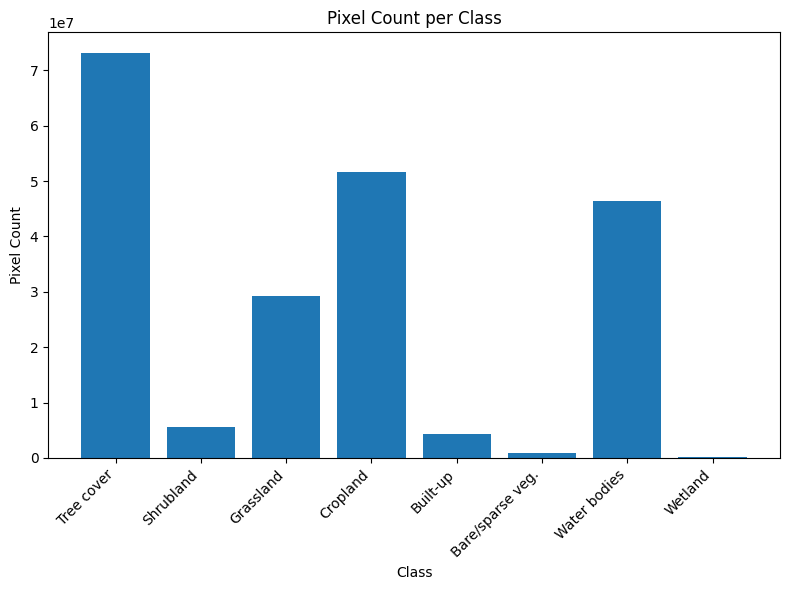

In [ ]:
pixel_class_counts = Counter()
for i in range(len(clean_dataset)):
    _, mask = clean_dataset[i]

    if hasattr(mask, "numpy"):
        mask = mask.numpy()
    class_counts = Counter(mask.flatten())
    pixel_class_counts.update(class_counts)

# Create lists for plotting
classes = sorted(pixel_class_counts.keys())
counts = [pixel_class_counts[c] for c in classes]
labels = [class_names.get(c, f"Class {c}") for c in classes]

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts)
plt.title("Pixel Count per Class")
plt.xlabel("Class")
plt.ylabel("Pixel Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

In [ ]:
from collections import Counter

# Determine dominant class per patch
dominant_classes = []

for i in range(len(clean_dataset)):
    _, mask = clean_dataset[i]
    mask = mask.numpy().flatten()

    dominant_class = Counter(mask).most_common(1)[0][0]

    dominant_classes.append(dominant_class)


indices = list(range(len(clean_dataset)))
train_indices, val_indices = train_test_split(
    indices, test_size=0.2, random_state=42, shuffle=True
)
ds_train = Subset(clean_dataset, train_indices)
ds_val = Subset(clean_dataset, val_indices)

train_loader = DataLoader(ds_train, batch_size=32, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=32, shuffle=True)

### Normalization and Augmentation

In [9]:
# we apply augmentation only in the training dataset
train_transform = loader.Compose(
    [
        loader.RandomHorizontalFlip(),
        loader.AddGaussianNoise(0.02),
        loader.Normalize13Band(),
    ],
    with_mask=True,
)

val_transform = loader.Compose([loader.Normalize13Band()], with_mask=True)

In [10]:
train_dataset = loader.TorchDataset(
    Subset(clean_dataset, train_indices), train_transform
)
val_dataset = loader.TorchDataset(Subset(clean_dataset, val_indices), val_transform)

In [11]:
ds_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
ds_valid = DataLoader(val_dataset, batch_size=32, shuffle=True)

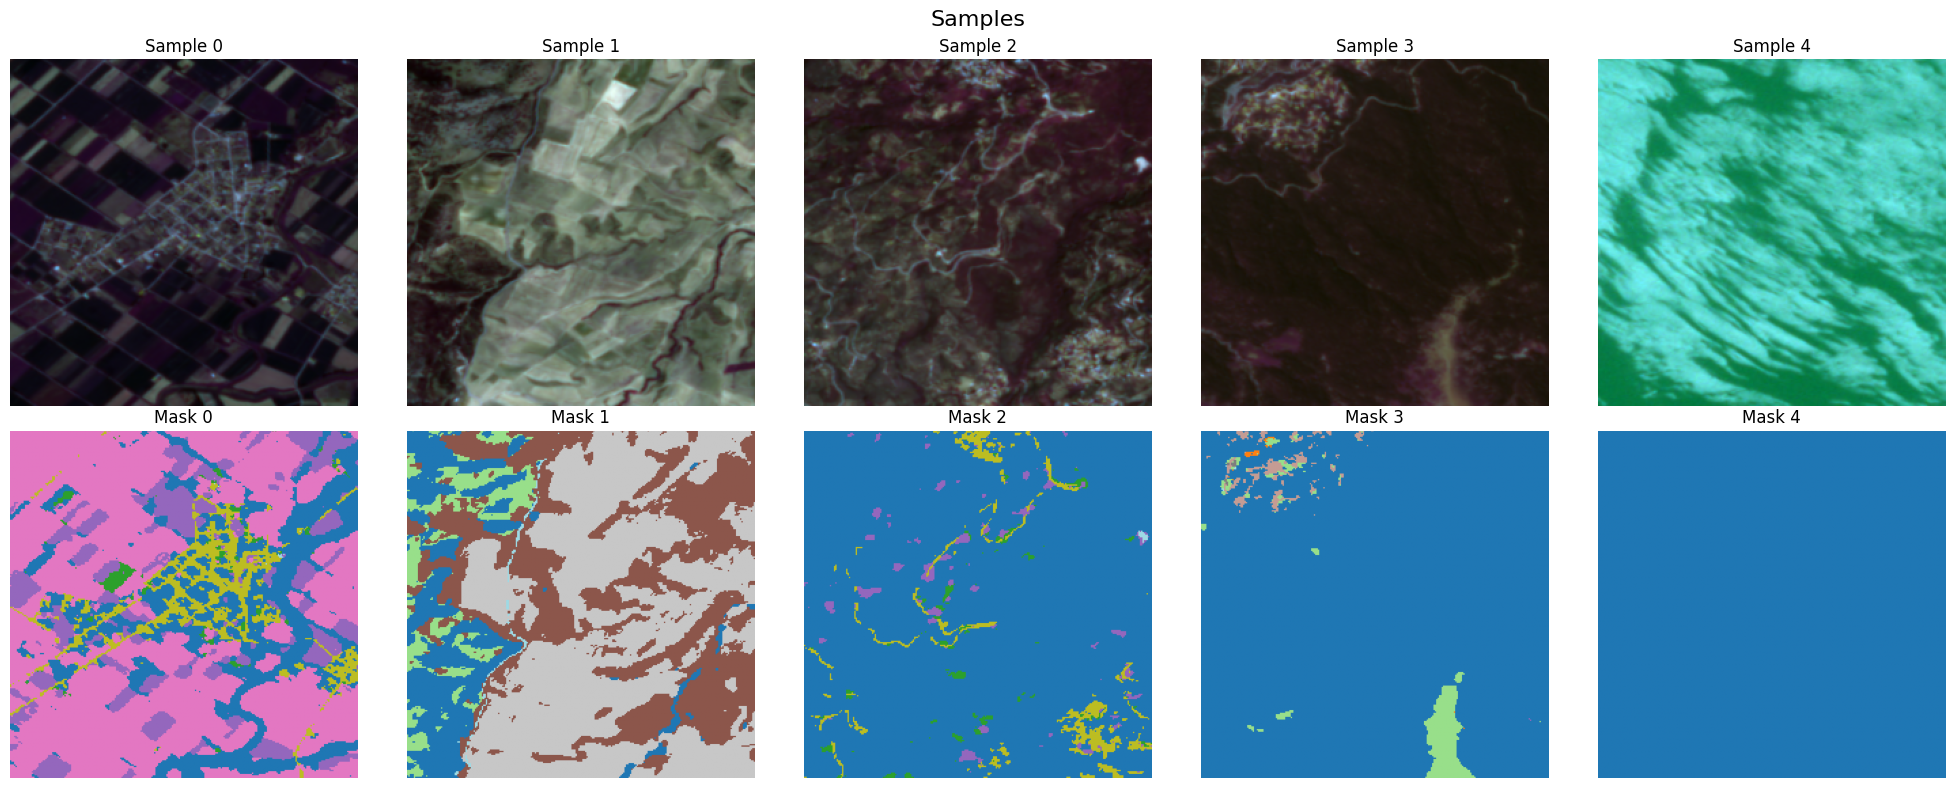

In [11]:
x_batch, y_batch = next(iter(ds_train))  # one batch from training
utils.visualize_samples(
    x_list=[x_batch[i] for i in range(5)],
    y_list=[y_batch[i] for i in range(5)],
    bands=(4, 3, 2),
)

## Model Training

In [14]:
# Architecture of base model

torch.cuda.empty_cache()

base_model = resnet18(ResNet18_Weights.SENTINEL2_ALL_MOCO)
base_model.to(device)
base_model.eval()

summary(base_model, input_size=(13, 256, 256))
print(base_model.layer1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]          40,768
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
          Identity-7           [-1, 64, 64, 64]               0
              ReLU-8           [-1, 64, 64, 64]               0
          Identity-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
       BasicBlock-13           [-1, 64, 64, 64]               0
           Conv2d-14           [-1, 64,

In [ ]:
# Train UNet
unet = model.UNet(base_model, num_classes=8)
unet = unet.to(device)

In [30]:
# Train UNet
unet = model.UNet(base_model, num_classes=8)
unet = unet.to(device)

en_lr = 1e-5
dec_lr = 5e-5

optimizer = optim.Adam(
    [
        {"params": unet.encoder0.parameters(), "lr": en_lr},
        {"params": unet.encoder1.parameters(), "lr": en_lr},
        {"params": unet.encoder2.parameters(), "lr": en_lr},
        {"params": unet.encoder3.parameters(), "lr": en_lr},
        {"params": unet.encoder4.parameters(), "lr": en_lr},
        {"params": unet.decoder_1.parameters(), "lr": dec_lr},
        {"params": unet.decoder_2.parameters(), "lr": dec_lr},
        {"params": unet.decoder_3.parameters(), "lr": dec_lr},
        {"params": unet.decoder_4.parameters(), "lr": dec_lr},
        {"params": unet.decoder_5.parameters(), "lr": dec_lr},
        {"params": unet.final.parameters(), "lr": dec_lr},
    ]
)


# Train the model
train_losses, val_losses, val_ds, val_miou = t.train_model(
    model=unet,
    num_classes=8,
    train_loader=ds_train,
    val_loader=ds_valid,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    save_name="output/exp_02.pt",
)

Epoch 1/50 [Train]:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch 1/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


Epoch 1/50: Train Loss: 1.1046, Val Loss: 0.7803, Mean IoU: 0.6919,  Dice: 0.1960
New best loss: 0.7803


Epoch 2/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.99it/s]


Epoch 2/50: Train Loss: 0.7122, Val Loss: 0.6749, Mean IoU: 0.7183,  Dice: 0.2224
New best loss: 0.6749


Epoch 3/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


Epoch 3/50: Train Loss: 0.6311, Val Loss: 0.6040, Mean IoU: 0.7133,  Dice: 0.2239
New best loss: 0.6040


Epoch 4/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.98it/s]


Epoch 4/50: Train Loss: 0.5648, Val Loss: 0.5572, Mean IoU: 0.7188,  Dice: 0.2266
New best loss: 0.5572


Epoch 5/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


Epoch 5/50: Train Loss: 0.5232, Val Loss: 0.5218, Mean IoU: 0.7267,  Dice: 0.2277
New best loss: 0.5218


Epoch 6/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.98it/s]


Epoch 6/50: Train Loss: 0.4877, Val Loss: 0.5004, Mean IoU: 0.7318,  Dice: 0.2303
New best loss: 0.5004


Epoch 7/50 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.01it/s]


Epoch 7/50: Train Loss: 0.4558, Val Loss: 0.4696, Mean IoU: 0.7284,  Dice: 0.2312
New best loss: 0.4696


Epoch 8/50 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.01it/s]


Epoch 8/50: Train Loss: 0.4251, Val Loss: 0.4494, Mean IoU: 0.7323,  Dice: 0.2313
New best loss: 0.4494


Epoch 9/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.94it/s]


Epoch 9/50: Train Loss: 0.4101, Val Loss: 0.4328, Mean IoU: 0.7358,  Dice: 0.2326
New best loss: 0.4328


Epoch 10/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.98it/s]


Epoch 10/50: Train Loss: 0.3891, Val Loss: 0.4157, Mean IoU: 0.7331,  Dice: 0.2349
New best loss: 0.4157


Epoch 11/50 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.02it/s]


Epoch 11/50: Train Loss: 0.3797, Val Loss: 0.4064, Mean IoU: 0.7387,  Dice: 0.2288
New best loss: 0.4064


Epoch 12/50 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.01it/s]


Epoch 12/50: Train Loss: 0.3589, Val Loss: 0.3908, Mean IoU: 0.7391,  Dice: 0.2369
New best loss: 0.3908


Epoch 13/50 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.00it/s]


Epoch 13/50: Train Loss: 0.3500, Val Loss: 0.3814, Mean IoU: 0.7348,  Dice: 0.2376
New best loss: 0.3814


Epoch 14/50 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.01it/s]


Epoch 14/50: Train Loss: 0.3407, Val Loss: 0.3756, Mean IoU: 0.7394,  Dice: 0.2373
New best loss: 0.3756


Epoch 15/50 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.01it/s]


Epoch 15/50: Train Loss: 0.3263, Val Loss: 0.3643, Mean IoU: 0.7426,  Dice: 0.2375
New best loss: 0.3643


Epoch 16/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


Epoch 16/50: Train Loss: 0.3190, Val Loss: 0.3663, Mean IoU: 0.7467,  Dice: 0.2407
 No improvement (1/5)


Epoch 17/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.91it/s]


Epoch 17/50: Train Loss: 0.3111, Val Loss: 0.3537, Mean IoU: 0.7412,  Dice: 0.2432
New best loss: 0.3537


Epoch 18/50 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.00it/s]


Epoch 18/50: Train Loss: 0.3034, Val Loss: 0.3471, Mean IoU: 0.7452,  Dice: 0.2427
New best loss: 0.3471


Epoch 19/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


Epoch 19/50: Train Loss: 0.2977, Val Loss: 0.3412, Mean IoU: 0.7468,  Dice: 0.2441
New best loss: 0.3412


Epoch 20/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.98it/s]


Epoch 20/50: Train Loss: 0.2932, Val Loss: 0.3368, Mean IoU: 0.7482,  Dice: 0.2456
New best loss: 0.3368


Epoch 21/50 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.01it/s]


Epoch 21/50: Train Loss: 0.2881, Val Loss: 0.3338, Mean IoU: 0.7453,  Dice: 0.2424
New best loss: 0.3338


Epoch 22/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.93it/s]


Epoch 22/50: Train Loss: 0.2821, Val Loss: 0.3300, Mean IoU: 0.7474,  Dice: 0.2466
New best loss: 0.3300


Epoch 23/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


Epoch 23/50: Train Loss: 0.2776, Val Loss: 0.3280, Mean IoU: 0.7464,  Dice: 0.2484
New best loss: 0.3280


Epoch 24/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.98it/s]


Epoch 24/50: Train Loss: 0.2719, Val Loss: 0.3195, Mean IoU: 0.7472,  Dice: 0.2524
New best loss: 0.3195


Epoch 25/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.76it/s]


Epoch 25/50: Train Loss: 0.2703, Val Loss: 0.3223, Mean IoU: 0.7506,  Dice: 0.2511
 No improvement (1/5)


Epoch 26/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


Epoch 26/50: Train Loss: 0.2675, Val Loss: 0.3156, Mean IoU: 0.7469,  Dice: 0.2504
New best loss: 0.3156


Epoch 27/50 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.00it/s]


Epoch 27/50: Train Loss: 0.2667, Val Loss: 0.3215, Mean IoU: 0.7491,  Dice: 0.2555
 No improvement (1/5)


Epoch 28/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.84it/s]


Epoch 28/50: Train Loss: 0.2618, Val Loss: 0.3100, Mean IoU: 0.7480,  Dice: 0.2511
New best loss: 0.3100


Epoch 29/50 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.01it/s]


Epoch 29/50: Train Loss: 0.2590, Val Loss: 0.3087, Mean IoU: 0.7492,  Dice: 0.2522
New best loss: 0.3087


Epoch 30/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.99it/s]


Epoch 30/50: Train Loss: 0.2574, Val Loss: 0.3060, Mean IoU: 0.7527,  Dice: 0.2470
New best loss: 0.3060


Epoch 31/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


Epoch 31/50: Train Loss: 0.2518, Val Loss: 0.3052, Mean IoU: 0.7486,  Dice: 0.2531
 No improvement (1/5)


Epoch 32/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.93it/s]


Epoch 32/50: Train Loss: 0.2490, Val Loss: 0.3036, Mean IoU: 0.7517,  Dice: 0.2527
New best loss: 0.3036


Epoch 33/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


Epoch 33/50: Train Loss: 0.2493, Val Loss: 0.3004, Mean IoU: 0.7518,  Dice: 0.2583
New best loss: 0.3004


Epoch 34/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.99it/s]


Epoch 34/50: Train Loss: 0.2461, Val Loss: 0.3007, Mean IoU: 0.7481,  Dice: 0.2537
 No improvement (1/5)


Epoch 35/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


Epoch 35/50: Train Loss: 0.2470, Val Loss: 0.2995, Mean IoU: 0.7517,  Dice: 0.2585
 No improvement (2/5)


Epoch 36/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.99it/s]


Epoch 36/50: Train Loss: 0.2430, Val Loss: 0.3026, Mean IoU: 0.7556,  Dice: 0.2575
 No improvement (3/5)


Epoch 37/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


Epoch 37/50: Train Loss: 0.2398, Val Loss: 0.2964, Mean IoU: 0.7506,  Dice: 0.2548
New best loss: 0.2964


Epoch 38/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.99it/s]


Epoch 38/50: Train Loss: 0.2389, Val Loss: 0.2942, Mean IoU: 0.7522,  Dice: 0.2563
New best loss: 0.2942


Epoch 39/50 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.02it/s]


Epoch 39/50: Train Loss: 0.2368, Val Loss: 0.2936, Mean IoU: 0.7495,  Dice: 0.2614
 No improvement (1/5)


Epoch 40/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


Epoch 40/50: Train Loss: 0.2340, Val Loss: 0.2961, Mean IoU: 0.7553,  Dice: 0.2605
 No improvement (2/5)


Epoch 41/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.99it/s]


Epoch 41/50: Train Loss: 0.2345, Val Loss: 0.2945, Mean IoU: 0.7571,  Dice: 0.2522
 No improvement (3/5)


Epoch 42/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.98it/s]


Epoch 42/50: Train Loss: 0.2309, Val Loss: 0.2911, Mean IoU: 0.7521,  Dice: 0.2539
New best loss: 0.2911


Epoch 43/50 [Val]: 100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


Epoch 43/50: Train Loss: 0.2322, Val Loss: 0.2905, Mean IoU: 0.7548,  Dice: 0.2584
 No improvement (1/5)


Epoch 44/50 [Train]:  35%|███▍      | 28/81 [00:11<00:21,  2.42it/s]


KeyboardInterrupt: 

In [28]:
t.evaluate_model(unet, ds_valid, nn.CrossEntropyLoss(), num_classes=8)

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 21/21 [00:03<00:00,  6.96it/s]

Test Loss: 0.3122,  mIoU: 0.7275, Dice: 0.2623


(0.31220987619355667, 0.7275323271751404, 0.2622573673725128)

In [ ]:
from collections import Counter

all_labels = []
for _, mask in ds_valid:
    all_labels.extend(mask.flatten().tolist())
print(Counter(all_labels))

Counter({0: 14555302, 3: 10385067, 6: 8867370, 2: 6202492, 1: 1134992, 4: 878321, 5: 210327, 7: 36849})


In [22]:
for x, y in ds_valid:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 13, 256, 256])
torch.Size([32, 256, 256])
